## Продвинутое машинное обучение: 
### Домашнее задание 2


In [239]:
import pickle
import datetime
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression

**Загрузим данные**

Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
- взять в тренировочный набор турниры с dateStart из 2019 года; 
- в тестовый — турниры с dateStart из 2020 года.


In [64]:
%%time
with open('./players.pkl', 'rb') as players_pickle:
    players = pd.DataFrame(pickle.load(players_pickle)).T
    
with open('./results.pkl', 'rb') as results_pickle:
    results = pickle.load(results_pickle)

with open('./tournaments.pkl', 'rb') as tournaments_pickle:
    tournaments = pickle.load(tournaments_pickle)

CPU times: user 31.5 s, sys: 7.87 s, total: 39.4 s
Wall time: 41.8 s


In [32]:
tournaments[145]

{'id': 145,
 'name': 'Прототурнир',
 'dateStart': '1999-01-01T00:00:00+03:00',
 'dateEnd': '2003-07-02T00:00:00+04:00',
 'type': {'id': 3, 'name': 'Синхрон'},
 'season': '/seasons/1',
 'orgcommittee': [],
 'synchData': None,
 'questionQty': None}

In [20]:
pd.to_datetime('2003-07-25T00:00:00+04:00').year

2003

In [417]:
train_tours = list()
test_tours = list()

train_year = 2019
test_year = 2020

# Проверка наличия статистики по ответам у все команд
def check_team_results(result):
    teams = list()
    quest_num = set()
    
    for team in result:
        
        if not team.get('mask', None) or not team.get('mask', None):
            return None
        quest_num.add(len(team.get('mask', None)))
        uniq_labels = set(team.get('mask', None))
        if len(uniq_labels) > 2:
            continue
        
        if not all([el.isnumeric() for el in uniq_labels]):
            continue
                
        # Будем добавлять в словарь только необходимую нам информацию
        team_dict = dict()
        team_dict['id'] = team['team']['id']
        team_dict['name'] = team['team']['name']
        team_dict['position'] = team['position']
        team_dict['num_quest'] = len(team['mask'])
        team_dict['mask'] = team['mask']
        team_dict['members'] = [member['player']['id'] for member in team['teamMembers']]
                
        teams.append(team_dict)
    if len(quest_num) != 1:
        return None
    return teams
        
        
for tournament_idx in tqdm(results):
    if not results[tournament_idx] or len(results[tournament_idx]) < 1:
        continue
    
    # Выберем только соревнования нужных нам лет
    tournament_year = pd.to_datetime(tournaments[tournament_idx]['dateStart']).year
    if tournament_year not in [2019, 2020]:
        continue
    
    # Отфильтруем соревнования без масок ответов и команды у которых есть неизвестные значения в ответах
    teams = check_team_results(results[tournament_idx])
    if teams:
        results_clean_teams[tournament_idx] = teams
    else:
        continue
        
    # Переформируем данные по соревнованиям оставив только самое необходимое
    tournament = dict()
    tournament['id'] = tournament_idx
    tournament['teams'] = teams
    
    # Распределение по выборкам
    if tournament_year == train_year:
        train_tours.append(tournament)
    elif tournament_year == test_year:
        test_tours.append(tournament)
    
            

100%|██████████| 5528/5528 [00:06<00:00, 895.18it/s] 


In [418]:
print(f'Количество соревнований в обучающей выборке: {len(train_tours)}')
print(f'Количество соревнований в тестовой выборке: {len(test_tours)}')

Количество соревнований в обучающей выборке: 601
Количество соревнований в тестовой выборке: 152


Сформируем основные статистики по каждому из игроков

**Анализ данных**

In [162]:
%%time
quest_num = list()
num_teams_tournament = list()

member_teams = defaultdict(set)
num_members = list()

correct_answers_num = list()
wrong_answers_num = list()
correct_answers_ratio = list()
wrong_answers_ratio = list()


for tournament in train_tours:
    quest_num.append(len(tournament['teams'][0]['mask']))
    num_teams_tournament.append(len(tournament['teams']))
    for team in tournament['teams']:
        answers = np.array(list(team['mask'])).astype('int')
        correct_answers_num.append(answers.sum())
        wrong_answers_num.append(len(answers) - correct_answers_num[-1])
        correct_answers_ratio.append(answers.mean())
        wrong_answers_ratio.append(1 - correct_answers_ratio[-1])
        num_members.append(len(team['members']))
        
    
        for member in team['members']:
            member_teams[member].add(team['id'])

member_team_num = [len(teams_list) for teams_list in member_teams.values()]

CPU times: user 2.29 s, sys: 46.6 ms, total: 2.34 s
Wall time: 2.4 s


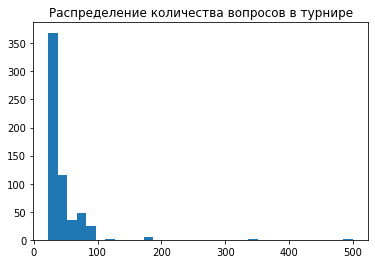

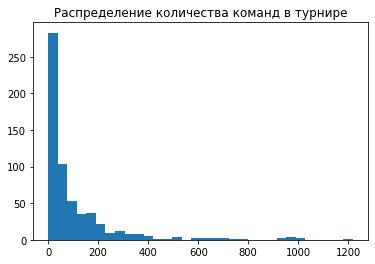

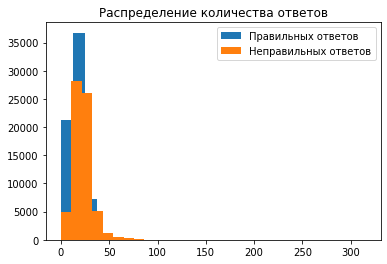

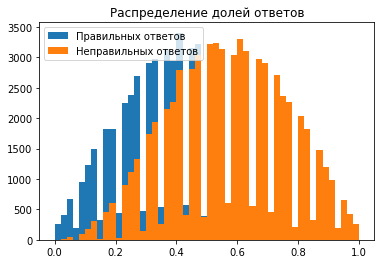

In [163]:
 

plt.hist(quest_num, bins=32)
plt.title('Распределение количества вопросов в турнире')
plt.show()

plt.hist(num_teams_tournament, bins=32)
plt.title('Распределение количества команд в турнире')
plt.show()

plt.hist(correct_answers_num, label='Правильных ответов', bins=25)
plt.hist(wrong_answers_num, label='Неправильных ответов', bins=25)
plt.title('Распределение количества ответов')
plt.legend()
plt.show()

# Расчески какие-то, связано видимо с тем что в среднем количество вопросов в среднем достаточно близко
plt.hist(correct_answers_ratio, label='Правильных ответов', bins=50)
plt.hist(wrong_answers_ratio, label='Неправильных ответов', bins=50)
plt.title('Распределение долей ответов')
plt.legend()
plt.show()

In [164]:
statistics = pd.DataFrame([])
for name, statistic in [
    ('Доля правильных ответов', correct_answers_ratio),
    ('Доля неправильных ответов', wrong_answers_ratio),
    ('Количество игроков в команде', num_members),
    ('Количество команд в турнире', num_teams_tournament),
    ('Количество вопросов в турнире', num_teams_tournament),
]:
    t = pd.Series(statistic, name=name).describe()
    statistics[name] = t
    
print("Основные статистики по распределениям некоторых параметров из обучающей выборки")
statistics.drop('count')

Основные статистики по распределениям некоторых параметров из обучающей выборки


,Доля правильных ответов,Доля неправильных ответов,Количество игроков в команде,Количество команд в турнире,Количество вопросов в турнире
mean,0.429010,0.570990,5.152816,110.623960,110.623960
std,0.191917,0.191917,1.219066,170.615557,170.615557
min,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.277778,0.430556,4.000000,22.000000,22.000000
50%,0.416667,0.583333,6.000000,45.000000,45.000000
75%,0.569444,0.722222,6.000000,124.000000,124.000000
max,1.000000,1.000000,13.000000,1218.000000,1218.000000


### Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков.
Замечания и подсказки:
 - повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
 - в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать;
 - скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
 - для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.



Построим обучающую выборку, в качестве обучения будет использоваться one-hot вектор (идентификатор игрока, идентификатор вопроса)

In [166]:
from scipy import sparse

In [362]:
%%time
members_set = list(member_teams.keys())
member_to_idx = dict(zip(members_set, range(len(members_set))))
idx_to_member = dict([(val, key) for (key, val) in member_to_idx.items()])
members_quest = defaultdict(list)
y = list()




quest_index = len(idx_to_member)

for tour in train_tours:
    tour_answers = list()
    for team in tour['teams']:
        answers = np.array(list(team['mask'])).astype('int')
        l = len(answers)
        
        
        tour_answers.append(answers)
        for local_question_idx, res in enumerate(answers):
            for member in team['members']:
                members_quest[member].append((quest_index + local_question_idx, res))
#                 y.append(res)
                
                
            
    
    
    # Создадим взвешенную версию ответа на вопрос по методу df
    quest_index += len(answers)

CPU times: user 6.55 s, sys: 1.8 s, total: 8.36 s
Wall time: 10.6 s


In [363]:
np.repeat([1,0,1], 2)

array([1, 1, 0, 0, 1, 1])

In [364]:
%%time
y = list()
x_coords = list()

for member in members_quest:
    member_id = member_to_idx[member]
    t_temp = [q[1] for q in members_quest[member]]
#     list(np.repeat([q[1] for q in members_quest[member]], 2))
    y_len = len(y)
    x_coords.extend([(y_len + i, q[0]) for i, q in enumerate(members_quest[member])])
    x_coords.extend([(y_len + i, member_id) for i, _ in enumerate(members_quest[member])])
    y.extend(t_temp)
    
x_coords = np.array(x_coords)

CPU times: user 31 s, sys: 2.71 s, total: 33.7 s
Wall time: 34.9 s


In [365]:
x_coords[:,1] == x_coords[:,0]

array([False, False, False, ..., False, False, False])

In [366]:
%%time
X = sparse.coo_matrix((np.ones(len(y) * 2), (x_coords[:,0], x_coords[:,1])), shape=(len(y), len(members_set) + quest_index)).tocsr()

CPU times: user 633 ms, sys: 222 ms, total: 855 ms
Wall time: 880 ms


In [367]:
X[0].to_dense()

<13715187x138134 sparse matrix of type '<class 'numpy.float64'>'
	with 27430374 stored elements in Compressed Sparse Row format>

Обучим модель на полученных данных и возьмем ее коэффициенты как рейтинг игрока/вопроса

In [420]:
model = LogisticRegression(n_jobs=4, C=8., max_iter=250, solver='sag')

In [ ]:
%%time
model.fit(X, y)

In [ ]:
np.sort(members_rating)

In [ ]:
import requests

def get_pos_from_api(id):
    url = f'https://rating.chgk.info/api/players/{id}/rating/last'
    position = -100
    req = requests.get(url).json()
    if req:
        position = int(req['rating_position'])
    return position

In [ ]:
members_rating = model.coef_[0][:len(member_to_idx)]
question_rating = model.coef_[0][len(member_to_idx):]

# Посмотрим на топ 50 игроков
top = [idx_to_member[member] for member in np.argsort(members_rating)[:-50:-1]]


In [ ]:
pred_rating = pd.Series(range(len(top)), index=top, name='predicted_rating')

In [ ]:
top_df = players.query('id in @top')
top_df['real_rating'] = top_df['id'].apply(get_pos_from_api)
top_df.loc[pred_rating.index, 'pred_rating'] = pred_rating.values

In [ ]:
top_df.sort_values('pred_rating')

Подсчитаем количество предсказанных топ 50 игроков

In [ ]:
(top_df['real_rating'] < 50).sum()

### Часть 3
Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:

  - предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
  - в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.

Для предсказания будем использовать сумму рейтингов всех участников команды

In [ ]:
def predict_team_result()

In [419]:
test_tours[0]

{'id': 5414,
 'teams': [{'id': 66120,
   'name': 'Чатик',
   'position': 1,
   'num_quest': 36,
   'mask': '111111111111111111111110111110101111',
   'members': [18490, 116901, 8532, 42346, 123190, 22482]},
  {'id': 312,
   'name': 'Социал-демократы',
   'position': 2.5,
   'num_quest': 36,
   'mask': '111111110111111111111011101010111111',
   'members': [19599, 3577, 15051, 25724, 34508, 61400]},
  {'id': 2,
   'name': 'Афина',
   'position': 2.5,
   'num_quest': 36,
   'mask': '110111111111111111110111111010111011',
   'members': [6482, 32458, 36120, 25882, 34846, 30475]},
  {'id': 72338,
   'name': 'Невыносимая тяжесть быть Иа',
   'position': 5,
   'num_quest': 36,
   'mask': '111111111111110111111110111010101011',
   'members': [135968, 157622, 164213, 102479, 134273, 87648]},
  {'id': 4032,
   'name': 'X-promt',
   'position': 5,
   'num_quest': 36,
   'mask': '111111110111111111110111100010111111',
   'members': [5007, 7737, 29487, 39152, 1352, 66403]},
  {'id': 46381,
   'name'